# Import lib

In [1]:
from utils import *
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# Dataset

## raw input

Raw data

In [2]:
# Load and preprocess
# Load
df = pd.read_csv(r'../data_raw/dataset.csv')

# Preprocess
df = df[df['company'].isna()==False]
df.drop(columns = ['platform'], inplace=True)

    # Standardize cost
df[['cogs', 'sales_cost', 'admin_cost']] = df[['cogs', 'sales_cost', 'admin_cost']].apply(
    lambda x: abs(x)
)

    # for_own/gov_own -> dummy var (0 or null -> 0; else -> 1)
df[['for_own', 'gov_own']] = df[['for_own', 'gov_own']].fillna(0)
df['for_own'] = df['for_own'].apply(
    lambda x: 0 if x == 0  else 1)
df['gov_own'] = df['gov_own'].apply(
    lambda x: 0 if x == 0  else 1)

    ## ----- Data prescaled ------- ##
df_raw = df.copy()
df_raw.sort_values(by=['company', 'year'], ascending=True, inplace=True)

To better reflect the value of the data, I scaled all vars based on GDP deflator of year 2010 for all vars (except percentage based vars)

In [3]:
# Scaled data to GDP deflator 2010
df_raw_deflator = df_raw.copy()
df_raw_deflator['deflator_scaled'] = df_raw_deflator['year'].map(
    {2015: 0.71, 2016: 0.70, 2017: 0.67,2018: 0.65,2019: 0.63,2020: 0.62,2021: 0.60,2022: 0.58,2023: 0.57,2024: 0.54})

# Scaled
df_raw_deflator[['ebitda', 'revenue', 'cogs', 'sales_cost',
       'admin_cost', 'net_op_profit', 'short_receive', 'in_stock',
       'invest_nav', 'long_receive', 'long_liability', 'short_liability',
       'cash', 'fixed_asset', 'other_long_asset', 'cwip', 'other_short_asset',
       'long_invest', 'equity_fund', 'other_fund', 'market_cap', 'ev']] = \
df_raw_deflator[['ebitda', 'revenue', 'cogs', 'sales_cost',
       'admin_cost', 'net_op_profit', 'short_receive', 'in_stock',
       'invest_nav', 'long_receive', 'long_liability', 'short_liability',
       'cash', 'fixed_asset', 'other_long_asset', 'cwip', 'other_short_asset',
       'long_invest', 'equity_fund', 'other_fund', 'market_cap', 'ev']].apply(lambda x:
                                                                        x*df_raw_deflator['deflator_scaled'])

# drop the scaler
df_raw_deflator.drop(columns='deflator_scaled', inplace=True)

Comment:
- Target variable (outcome): ebitda dummy, revenue, roa, roe, roic, roce, value_added (see vars_used.txt file for details)
- As raw input, all the rest vars are used as features

## target var eda

REGRESSION PROBLEM

REVENUE:
+ After applying log, skew and kurtosis of revenue decreases -> good
+ The distribution of revenue turns into normal dist

-------- Original -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
revenue,18761.0,1.960506e+12,1.098396e+13,726643.1,7.247256e+10,2.417693e+11,9.353446e+11,3.810080e+14,18.2543,423.6201


------- Log scaled ------------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
revenue,18761.0,26.2645,2.0033,13.4962,25.0065,26.2112,27.5642,33.5738,-0.1356,0.8246


<Axes: title={'center': 'Revenue Log'}, xlabel='revenue', ylabel='Count'>

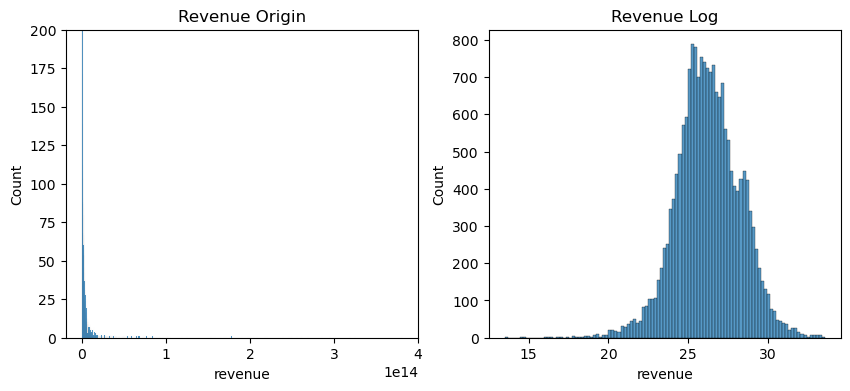

In [4]:
# Revenue
df_rev = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit', 'roa','roe', 'roic', 'roce'])
  # Filter for rev > 0
df_rev = df_rev[df_rev['revenue']>0]
print('-------- Original -----------')
display(eda_describe(df_rev.drop(columns='year'))[:1])
print('------- Log scaled ------------')
df_rev_log = df_rev.copy()
df_rev_log['revenue'] = df_rev_log['revenue'].apply(lambda x: np.log(x))
display(eda_describe(df_rev_log.drop(columns='year'))[:1])
    # Chart
f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title('Revenue Origin')
ax[0].set_ylim(top=200)
sns.histplot(x=df_rev['revenue'], ax=ax[0])
ax[1].set_title('Revenue Log')
sns.histplot(x=df_rev_log['revenue'], ax=ax[1])

ROA, ROE, ROIC, ROCE:
+ Since mean and median of these metric are close, the data is likely symetric (though skew might be high)
+ SO no transformation needed

In [5]:
# roa roe roic roce
df_roa = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roic', 'roce', 'revenue'])
df_roe = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roa', 'roic', 'roce', 'revenue'])
df_roic = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roa', 'roce', 'revenue'])
df_roce = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roa', 'roic', 'revenue'])

# Describe
print('-------- ROA -----------')
display(eda_describe(df_roa[['roa']]))
print('-------- ROE -----------')
display(eda_describe(df_roe[['roe']]))
print('-------- ROIC -----------')
display(eda_describe(df_roic[['roic']]))
print('-------- ROCE -----------')
display(eda_describe(df_roce[['roce']]))

-------- ROA -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roa,19080.0,0.0343,0.1528,-9.5844,0.0019,0.0264,0.0695,4.5785,-20.6086,1172.7049


-------- ROE -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roe,19080.0,0.0973,1.6631,-60.7224,0.0087,0.0716,0.155,111.7216,20.7107,1877.2417


-------- ROIC -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roic,19080.0,0.0472,4.7567,-552.8697,0.0,0.0479,0.1161,262.7942,-73.5527,10088.101


-------- ROCE -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roce,19080.0,0.0959,1.3622,-59.4495,0.0029,0.0712,0.1606,160.676,81.4723,10338.7582


CLASSIFICATION PROBLEM

VALUE-ADD

In [6]:
# Value added
df_valad = df_rev.copy()
df_valad['value_add'] = df_valad['revenue'] - df_valad['cogs'] - df_valad['sales_cost'] - df_valad['admin_cost']
df_valad.drop(columns=['revenue', 'cogs', 'sales_cost', 'admin_cost'], inplace=True)
df_valad['value_add'] = df_valad['value_add'].apply(lambda x: 1 if x > 0 else (0 if x <=0 else x))
df_valad.groupby('value_add')['value_add'].count()

value_add
0.0     3348
1.0    15409
Name: value_add, dtype: int64

EBITDA

In [7]:
# EBITDA
df_ebitda = df_raw_deflator.drop(columns=['revenue', 'net_op_profit', 'roa','roe', 'roic', 'roce'])
df_ebitda['ebitda'] = df_ebitda['ebitda'].apply(lambda x: 1 if x > 0 else (0 if x <=0 else x))
df_ebitda.groupby('ebitda')['ebitda'].count()

ebitda
0.0     3302
1.0    15486
Name: ebitda, dtype: int64

## null treatment

Comment:
+ I have 7 target vars, equivalent to 7 different input dataset
+ So I treat each seperately
+ Rule: keep all companies that have data for at least 4 consecutive years, preserving temporal \
characteristic of the data, and each obs within lacks less than 6 values.
+ For example: (2015,2016,2017 = invalid); (2015,2016,2017,2018 = valid); (2015,2016,2017,2019 = invalid)
+ The rest will be imputed using KNN

SELECT DATA

In [ ]:
# Revenue data
df_revenue = select_data(df_rev_log.drop(columns = ['ev', 'market_cap'])) # drop systematic null cols
# ROA
df_roa = select_data(df_roa.drop(columns = ['ev', 'market_cap']))
# ROE
df_roe = select_data(df_roe.drop(columns = ['ev', 'market_cap']))
# ROIC
df_roic = select_data(df_roic.drop(columns = ['ev', 'market_cap']))
# ROCE
df_roce = select_data(df_roce.drop(columns = ['ev', 'market_cap']))


# Value add
df_value = select_data(df_valad.drop(columns = ['ev', 'market_cap']))
# Ebitda
df_ebitda = select_data(df_ebitda.drop(columns = ['ev', 'market_cap']))

IMPUTATION

In [9]:
# Filled
#Reg
df_revenue = impute(df_revenue)
df_value = impute(df_value)
df_ebitda = impute(df_ebitda)
df_roa = impute(df_roa)
df_roe = impute(df_roe)
df_roic = impute(df_roic)
df_roce = impute(df_roce)

#class
df_value = impute(df_value)
df_value['value_add'] = df_value['value_add'].apply(lambda x: 1 if x > 0.5 else 0)

df_ebitda = impute(df_ebitda)
df_ebitda['ebitda'] = df_ebitda['ebitda'].apply(lambda x: 1 if x > 0.5 else 0)

## feature vars eda

In [10]:
# feature
features = df_revenue.drop(columns=['company', 'year', 'revenue'])

# Check for multicollineairty
vif_data = pd.DataFrame()
vif_data['feature'] = features.columns
vif_data['VIF'] = [vif(features.values, i) for i in range(len(features.columns))]
vif_data.sort_values(by='VIF', ascending =False)

,feature,VIF
10,fixed_asset,96.987398
7,long_liability,78.646240
8,short_liability,65.785395
15,equity_fund,51.622742
3,short_receive,21.481738
9,cash,14.905612
11,other_long_asset,12.906662
6,long_receive,12.587266
13,other_short_asset,8.227871
0,cogs,7.973851


In [11]:
# Modified data
features2 = features.copy()
features2['expense'] = features2['cogs'] + features2['sales_cost'] + features2['admin_cost']
features2.drop(columns=['cogs', 'sales_cost', 'admin_cost', 'fixed_asset',
                        'short_liability', 'equity_fund', 'short_receive', 'cash'], inplace=True)

vif_data2 = pd.DataFrame()
vif_data2['feature'] = features2.columns
vif_data2['VIF'] = [vif(features2.values, i) for i in range(len(features2.columns))]
vif_data2.sort_values(by='VIF', ascending =False)

,feature,VIF
5,cwip,4.509406
4,other_long_asset,4.298935
3,long_liability,3.846497
6,other_short_asset,3.780795
11,expense,3.062575
7,long_invest,3.041479
2,long_receive,2.975026
0,in_stock,2.043206
1,invest_nav,1.882151
9,gov_own,1.176256


Comment:
+ The modified data include: aggregating all cost into one var called "expense", \
and removing 'fixed_asset','short_liability', 'equity_fund', 'short_receive', 'cash'
+ This preserves 12 out of 19 original vars while avoiding serious multicollinearity

## input data for modelling

Comment:
+ As part of the EDA process, only 12 vars are kept and expense will be transformed (for details, check 'Dataset')
+ To make forecasting meaningful, raw predictors must be from the past. So the input predictors might be lagged 1 (base lag)

In [12]:
# Input data
df_revenue = final_data(df_revenue, 'revenue')
df_roa = final_data(df_roa, 'roa')
df_roe = final_data(df_roe, 'roe')
df_roce = final_data(df_roce, 'roce')
df_roic = final_data(df_roic, 'roic')

df_ebitda = final_data(df_ebitda, 'ebitda')
df_value = final_data(df_value, 'value_add')

In [16]:
name = ['revenue', 'roa', 'roe', 'roce', 'roic', 'ebitda', 'value_ad']
data = [df_revenue, df_roa, df_roe, df_roce, df_roic, df_ebitda, df_value]

for idx, dta in dict(zip(name, data)).items():
    dta.to_csv(f'df_{idx}.csv', index=False)